In [1]:
# /home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/filted_EF_Proton_4e13_1e15_dataset.npz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot

def load_diff_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    hitE= data['hitsE']
    hitM= data['hitsM']
    params = data['params']
    param_names = data['param_names']
    params_df = pd.DataFrame(params, columns=param_names)
    return hitE, hitM, params_df

EF_hitE, EF_hitM, EF_params_df = load_diff_data('/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset.npz')
QF_hitE, QF_hitM, QF_params_df = load_diff_data('/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset.npz')
SF_hitE, SF_hitM, SF_params_df = load_diff_data('/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_SF_Proton_4e13_1e15_dataset.npz')
QG_hitE, QG_hitM, QG_params_df = load_diff_data('/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset.npz')
_,_,exp_2022_df=load_diff_data("/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose.npz")
exp_2022_df['weight']=np.ones(len(exp_2022_df))/355/86400

def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 / (86400)
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df

EF_params_df = give_weights(EF_params_df)
QF_params_df = give_weights(QF_params_df)
SF_params_df = give_weights(SF_params_df)
QG_params_df = give_weights(QG_params_df)
print(EF_params_df.columns)
# print(EF_params_df.shape, QF_params_df.shape, SF_params_df.shape, QG_params_df.shape)
# print(EF_params_df['weight'].sum(), QF_params_df['weight'].sum(), QG_params_df['weight'].sum())




def open_file(file_name):
    with uproot.open(file_name) as file:
        tree = file["Rec"]
        branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM1","NuW2","weightGaisser"]
        df = tree.arrays(branches_to_read, library="pd")
        all_weights = df['weightGaisser'].sum()
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights:", all_weights)
        cuts_indices = (df['rec_Eage'] > 0) & (df['Redge'] > 0) & (df["NuW2"]>0) & (df["NpE3"]>80)
        df_cut = df[cuts_indices].copy() 
        
        df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM1"])/(df_cut["NpE3"]+1))
        df_cut["weight"]=df_cut["weightGaisser"]
        df_cut["trueE"]=df_cut["E"]
        df_cut["Eage"]=df_cut["rec_Eage"]
        print(f"     Entries after cut: {df_cut.shape[0]}")
        del df
        return df_cut
proton_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
print(proton_df.columns)
from xgboost import XGBRegressor
model = XGBRegressor()
model.load_model("/home/zhonghua/Filt_Event/models/energy_correction_xgb_NuW2_8-12.json")

def energy_correction(df):
    theta=df["rec_theta"].values
    # df["NuW2"]  theta 作为输入
    feature_data = np.column_stack((df["NuW2"].values, theta))
    corrected_energy = model.predict(feature_data)
    df["recE"]=corrected_energy  # log10(TeV)
    return df

proton_df=energy_correction(proton_df)




Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'recE', 'rec_x', 'rec_y',
       'rec_theta', 'rec_phi', 'trueE', 'NuW2', 'NpE3', 'NuM1', 'core_x',
       'core_y', 'theta'],
      dtype='object')
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights: 189.58057618423743
     Entries after cut: 9799316
Index(['E', 'theta', 'phi', 'corex', 'corey', 'rec_x', 'rec_y', 'rec_theta',
       'rec_phi', 'rec_Eage', 'Redge', 'NpE3', 'NuM1', 'NuW2', 'weightGaisser',
       'R_ue', 'weight', 'trueE', 'Eage'],
      dtype='object')


/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [ ]:
# EF_params_df['weight']=EF_params_df['weight']*0.839520
# QF_params_df['weight']=QF_params_df['weight']*0.839520
# SF_params_df['weight']=SF_params_df['weight']*0.839520
# QG_params_df['weight']=QG_params_df['weight']*0.43
print(EF_params_df['weight'].sum(), QF_params_df['weight'].sum(), SF_params_df['weight'].sum())
print(QG_params_df['weight'].sum())


88.23094709083271 88.65280499181854 1.692173137162559
11.51880941291957


In [ ]:
plt.hist(EF_params_df['recE'], bins=50, alpha=0.5, label='EF', weights=EF_params_df['weight'])
plt.hist(QF_params_df['recE'], bins=50, alpha=0.5, label='QF',  weights=QF_params_df['weight'])
plt.hist(SF_params_df['recE'], bins=50, alpha=0.5, label='SF',  weights=SF_params_df['weight'])
plt.xlabel('Reconstructed Energy (recE)')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()
# Eage
plt.hist(EF_params_df['Eage'], bins=50, alpha=0.5, label='EF', weights=EF_params_df['weight'])
plt.hist(QF_params_df['Eage'], bins=50, alpha=0.5, label='QF',  weights=QF_params_df['weight'])
plt.hist(SF_params_df['Eage'], bins=100, alpha=0.5, label='SF', weights=SF_params_df['weight'])
plt.xlabel('Eage')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.show()
# R_mean
plt.hist(EF_params_df['R_mean'], bins=50, alpha=0.5, label='EF', weights=EF_params_df['weight'])
plt.hist(QF_params_df['R_mean'], bins=50, alpha=0.5, label='QF',  weights=QF_params_df['weight'])
plt.hist(SF_params_df['R_mean'], bins=100, alpha=0.5, label='SF', weights=SF_params_df['weight'])
plt.xlabel('R_mean')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.show()


In [3]:
def load_monoople():
    import uproot
    import numpy as np
    file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]

    # 加载磁单极子的数据 /home/zhonghua/data/Dataset_Filted/1e10_V03/Monopole_combined_filted_1e10_V03_dataset.npz
    monopole_data=np.load("/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset.npz",allow_pickle=True)
    monopole_params=monopole_data["params"]
    params_name=monopole_data["param_names"]
    monopole_df=pd.DataFrame(monopole_params,columns=params_name)
    theta_degrees = monopole_df["rec_theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)

    monopole_df["weight"] = monopole_weights
    print(len(monopole_df["weight"].values),np.sum(monopole_df["weight"].values))

    return monopole_df

monopole_df=load_monoople()


104840 3.007714151577215e-05


In [204]:
import pandas as pd
import numpy as np
# log10TeV_low = 1.7969200611114502
log10TeV_low = 1.95
log10TeV_high = 2.1131057739257812
theta_low = 10.0 * np.pi/180.0
theta_high = 30.0 * np.pi/180.0
rec_r_low = 320
rec_r_high = 420
age_low = 0.8
age_high = 1.2
Rmean_low = 25
Rmean_high = 45




def selection(params_df_0):
    params_df = params_df_0[(params_df_0["NpE3"]>80) & (params_df_0["NuW2"]>0)].copy()
    rec_x = pd.to_numeric(params_df["rec_x"], errors='coerce')
    rec_y = pd.to_numeric(params_df["rec_y"], errors='coerce')
    params_df["rec_r"] = np.sqrt(rec_x**2 + rec_y**2)

    current_mask = pd.Series(True, index=params_df.index)
    
    initial_weight = params_df['weight'].sum()
    prev_weight = initial_weight

    mask_rec_r = (params_df['rec_r'] >= rec_r_low) & (params_df['rec_r'] <= rec_r_high)
    current_mask = current_mask & mask_rec_r
    curr_weight = params_df.loc[current_mask, 'weight'].sum()
    print(f"rec_r cut: {curr_weight/prev_weight:.3%} || {curr_weight:.5f}/{prev_weight:.5f}")
    prev_weight = curr_weight
    
    mask_rec_theta = (params_df['rec_theta'] >= theta_low) & (params_df['rec_theta'] <= theta_high)
    current_mask = current_mask & mask_rec_theta
    curr_weight = params_df.loc[current_mask, 'weight'].sum()
    print(f"rec_theta cut: {curr_weight/prev_weight:.3%} || {curr_weight:.5f}/{prev_weight:.5f}")
    prev_weight = curr_weight

    mask_recE = (params_df['recE'] >= log10TeV_low) & (params_df['recE'] <= log10TeV_high)
    current_mask = current_mask & mask_recE
    curr_weight = params_df.loc[current_mask, 'weight'].sum()
    print(f"recE cut: {curr_weight/prev_weight:.3%} || {curr_weight:.5f}/{prev_weight:.5f}")
    prev_weight = curr_weight

    mask_Eage = (params_df['Eage'] >= age_low) & (params_df['Eage'] <= age_high)
    current_mask = current_mask & mask_Eage
    curr_weight = params_df.loc[current_mask, 'weight'].sum()
    print(f"Eage cut: {curr_weight/prev_weight:.3%} || {curr_weight:.5f}/{prev_weight:.5f}")
    prev_weight = curr_weight

    mask_Rmean = (params_df['R_mean'] >= Rmean_low) & (params_df['R_mean'] <= Rmean_high)
    current_mask = current_mask & mask_Rmean
    curr_weight = params_df.loc[current_mask, 'weight'].sum()
    print(f"R_mean cut: {curr_weight/prev_weight:.3%} || {curr_weight:.5f}/{prev_weight:.5f}")
    
    print(f"Total weighted events selected: {curr_weight:.5f}/{prev_weight:.5f} ({curr_weight/initial_weight:.3%})")
    print(f"one year expected events: {curr_weight*86400*365:.3f}")
    print("--------------------------------------------------")
    
    return params_df.loc[current_mask]

selected_EF_params = selection(EF_params_df)
selected_QF_params = selection(QF_params_df)
selected_QG_params = selection(QG_params_df)
# selected_proton_df = selection(proton_df)
selected_2022_df = selection(exp_2022_df)

selected_monopole_df=selection(monopole_df)


rec_r cut: 39.242% || 34.62167/88.22530
rec_theta cut: 59.304% || 20.53219/34.62167
recE cut: 4.563% || 0.93679/20.53219
Eage cut: 35.193% || 0.32969/0.93679
R_mean cut: 65.421% || 0.21569/0.32969
Total weighted events selected: 0.21569/0.32969 (0.244%)
one year expected events: 6801878.891
--------------------------------------------------
rec_r cut: 39.196% || 34.74599/88.64600
rec_theta cut: 59.501% || 20.67435/34.74599
recE cut: 4.061% || 0.83962/20.67435
Eage cut: 33.265% || 0.27930/0.83962
R_mean cut: 64.321% || 0.17965/0.27930
Total weighted events selected: 0.17965/0.27930 (0.203%)
one year expected events: 5665431.007
--------------------------------------------------
rec_r cut: 22.621% || 2.60563/11.51881
rec_theta cut: 56.550% || 1.47347/2.60563
recE cut: 38.884% || 0.57294/1.47347
Eage cut: 33.842% || 0.19389/0.57294
R_mean cut: 68.012% || 0.13187/0.19389
Total weighted events selected: 0.13187/0.19389 (1.145%)
one year expected events: 4158681.779
-------------------------

In [190]:
selected_2022_df=selected_2022_df[selected_2022_df['R_ue']<-6]
selected_2022_df['weight'].sum()*365*86400
(30.770-31.236)/31.236

selected_monopole_df_nomuon=selected_monopole_df[selected_monopole_df['R_ue']<-6]
selected_monopole_df_nomuon['weight'].sum()*365*86400


12.403478775244604

In [ ]:
# plt.hist(selected_EF_params['recE'], bins=50, alpha=0.5, label='EF', weights=selected_EF_params['weight'], density=True)
# plt.hist(selected_QF_params['recE'], bins=50, alpha=0.5, label='QF',  weights=selected_QF_params['weight'], density=True)
# plt.hist(selected_SF_params['recE'], bins=50, alpha=0.5, label='SF',  weights=selected_SF_params['weight'], density=True)
plt.hist(selected_proton_df['recE'], bins=50, alpha=0.5, label='Proton',  weights=selected_proton_df['weight'], density=True)
plt.hist(exp_2022_df['recE'], bins=50, alpha=0.5, label='Exp_2022', density=True)
plt.xlabel('Reconstructed Energy (recE)')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()
R_ue_range = (-9,1)

plt.hist(selected_EF_params['R_ue'], bins=100, alpha=0.5, range=R_ue_range, label='EF', density=True)
plt.hist(selected_QF_params['R_ue'], bins=100, alpha=0.4, range=R_ue_range, label='QF',  density=True)
plt.hist(selected_QG_params['R_ue'], bins=100, alpha=0.2, range=R_ue_range, label='QG',  density=True)

plt.xlabel('R_ue')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()
NuM1_range = (0, 200)
print(selected_EF_params['NuM1'].min(), selected_EF_params['NuM1'].max())
plt.hist(selected_EF_params['NuM1'], bins=50, alpha=1, range=NuM1_range , label='EF', density=True, histtype='step', linewidth=1)
plt.hist(selected_QF_params['NuM1'], bins=50, alpha=1, range=NuM1_range, label='QF',  density=True, histtype='step', linewidth=1)
plt.hist(selected_QG_params['NuM1'], bins=50, alpha=1, range=NuM1_range, label='QG',  density=True, histtype='step', linewidth=1)

plt.xlabel('NuM1')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()


In [ ]:




def NuM1_fit_landau_integrated(proton_df_age_infit, bins=300, ranges=[0, 300]):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.integrate import quad # <--- 引入积分函数

   
    hist_y, bin_edges = np.histogram(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges, 
        weights=proton_df_age_infit["weight"]
    )
    
    # 算出 bin 宽度
    bin_width = (ranges[1] - ranges[0]) / bins
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 筛选拟合数据
    mask = hist_y > 0
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    sigma_fit = np.sqrt(y_fit)
    sigma_fit[sigma_fit == 0] = 1e-10

    # 2. 定义函数 (Moyal/Landau)
    # 注意：这里的 amplitude 实际上是“总面积”的一个缩放因子，因为 pdf 积分是 1
    # 如果 hist_y 是 Rate，那么 amplitude 大概就是总 Rate
    def landau_func(x, amplitude, mpv, width):
        return amplitude * moyal.pdf(x, loc=mpv, scale=width)

    # 3. 拟合
    # 改进初始猜测
    p0 = [np.sum(y_fit)*bin_width, x_fit[np.argmax(y_fit)], 10.0] 
    bounds = ([0, 0, 0.1], [np.inf, 300, 100])

    try:
        popt, pcov = curve_fit(landau_func, x_fit, y_fit, p0=p0, sigma=sigma_fit, absolute_sigma=True, bounds=bounds)
        fit_success = True
        print(f"拟合参数: Amp={popt[0]:.2e}, MPV={popt[1]:.2f}, Width={popt[2]:.2f}")
    except Exception as e:
        print(f"拟合失败: {e}")
        fit_success = False
        popt = [0, 0, 0]

    # ======================================================
    # 4. 关键步骤：积分计算 NuM1 在 [0, 1] 区间的 Rate
    # ======================================================
    if fit_success:
        # 定义被积函数 (即我们拟合出来的函数)
        def fitted_curve(x):
            return landau_func(x, *popt)
        
        # 对 0 到 1 进行积分
        # 这里的 1 实际上是 bin_width。如果你的第一格是 0-1，就积 0-1。
        rate_integrated, error = quad(fitted_curve, 0, 1)
        
        print(f"========================================")
        print(f"直接取函数值 f(0):       {fitted_curve(0):.4e}")
        print(f"积分区间 [0, 1] 的 Rate: {rate_integrated:.4e} Hz")
        print(f"one year expect: {rate_integrated*86400*365:.2f} events")
        print(f"error estimate: {error:.4e}")
        print(f"========================================")
    else:
        rate_integrated = 0

    # 5. 绘图
    plt.hist(proton_df_age_infit["NuM1"], bins=bins, range=ranges,
             histtype='step', weights=proton_df_age_infit["weight"],
             label="Proton Data", color='black')

    if fit_success:
        x_plot = np.linspace(ranges[0],ranges[1], 1000)
        plt.plot(x_plot, landau_func(x_plot, *popt), 'r-', label="Landau Fit")
        
        # 画出我们积分的那个小区域 (0-1)
        x_area = np.linspace(0, 1, 50)
        plt.fill_between(x_area, landau_func(x_area, *popt), color='red', alpha=0.5, label="Integral Region [0-1]")

    plt.xlabel("NuM1")
    plt.ylabel("Rate / Hz")
    plt.legend()
    plt.yscale('log') # 推荐打开 log 看 0 处的细节
    plt.show()

    return rate_integrated

EF_rates, QF_rates, QG_rates, whole_rates = [], [], [], []
for NuM1 in range(100, 220, 20):
    # bins=int(NuM1/2)
    bins=int(NuM1)
    ranges=[0,NuM1]

    EF_0_rate=NuM1_fit_landau_integrated(selected_EF_params, bins=bins, ranges=ranges)
    QF_0_rate=NuM1_fit_landau_integrated(selected_QF_params, bins=bins, ranges=ranges)
    QG_0_rate=NuM1_fit_landau_integrated(selected_QG_params, bins=bins, ranges=ranges)
    # QF_whole_rate=NuM1_fit_landau_integrated(selected_proton_df, bins=bins, ranges=ranges)
    EF_rates.append(EF_0_rate)
    QF_rates.append(QF_0_rate)
    QG_rates.append(QG_0_rate)
    # whole_rates.append(QF_whole_rate)

EF_rates, QF_rates, QG_rates, whole_rates = np.array(EF_rates), np.array(QF_rates), np.array(QG_rates), np.array(whole_rates)



In [6]:
# one year
EF_rates *= 86400*365
QF_rates *= 86400*365
QG_rates *= 86400*365
whole_rates *= 86400*365

print(EF_rates)
print(QF_rates)
print(QG_rates)
# print(whole_rates)


[3276.38162258 2042.49836044 1557.56952094 1597.3837365  1679.2297568
 1714.08616698]
[157.65005876  70.70814155  44.38495835  52.93623376  61.31263234
  64.3013147 ]
[131.08006296  57.57663177  11.76338211  11.86561228  13.8146097
  14.7247379 ]


In [8]:
# one year
EF_rates *= 86400*365
QF_rates *= 86400*365
QG_rates *= 86400*365
whole_rates *= 86400*365

print(EF_rates)
print(QF_rates)
print(QG_rates)
# print(whole_rates)


[626.82330836 440.32927305 465.54376852 526.57330835 556.82714701
 566.42080405]
[16.78303518  7.62460131  8.67179736 11.58747547 13.20446432 13.833086  ]
[28.66808522 10.21215318  4.91622714  6.06758863  6.91771266  7.34452642]


Indices of EF events with R_ue < -7: [49275, 311750]


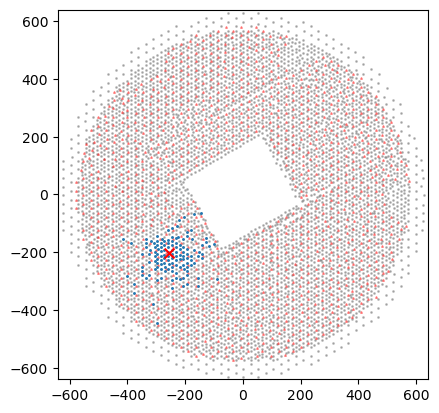

label                  14
weight           0.000231
R_ue            -6.910262
R_mean          32.909627
Eage             0.907169
recE             2.068736
rec_x         -253.871902
rec_y          -203.13855
rec_theta        0.364865
rec_phi          0.292334
trueE        118860.71875
NuW2             2.144501
NpE3           813.321777
NuM1                  0.0
core_x        -207.003315
core_y         252.798654
theta             0.37179
rec_r          325.140298
Name: 49275, dtype: object

In [59]:

index_EF = selected_EF_params[selected_EF_params['R_ue'] < -6].index
print("Indices of EF events with R_ue < -7:", index_EF.tolist())
# print(selected_EF_params.loc[index_EF])
n=0
index_EF_n=index_EF[n]
check_hitE = EF_hitE[index_EF][n]
check_hitM = EF_hitM[index_EF][n]
# print("check_hitE shape:", check_hitE)
ED_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/ED_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
MD_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/MD_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
plt.scatter(ED_pos["x"],ED_pos["y"],marker="o", s=1, c="gray", alpha=0.5, label="ED")
plt.scatter(MD_pos["x"],MD_pos["y"],marker="^",  s=1, c="r", alpha=0.5, label="MD")
plt.scatter(check_hitE[:,0], check_hitE[:,1], s=1)
plt.scatter(selected_EF_params.loc[index_EF_n]['rec_x'], selected_EF_params.loc[index_EF_n]['rec_y'], marker='x', s=50, c='red', label='Reconstructed Core')
plt.gca().set_aspect('equal') 
plt.xlim(-640, 640)
plt.ylim(-640, 640)
plt.show()
selected_EF_params.loc[index_EF[0]]


In [ ]:
for i in range(10, 30):
    index_EF = selected_SF_params.index[i]
    check_hitE = SF_hitE[index_EF]
    check_hitM = SF_hitM[index_EF]
    # print("check_hitE shape:", check_hitE)
    ED_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/ED_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
    MD_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/MD_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
    plt.scatter(ED_pos["x"],ED_pos["y"],marker="o", s=1, c="gray", alpha=0.5, label="ED")
    plt.scatter(MD_pos["x"],MD_pos["y"],marker="^",  s=1, c="r", alpha=0.5, label="MD")
    plt.scatter(check_hitE[:,0], check_hitE[:,1], s=1)
    plt.scatter(selected_SF_params.loc[index_EF]['rec_x'], selected_SF_params.loc[index_EF]['rec_y'], marker='x', s=50, c='red', label='Reconstructed Core')
    plt.gca().set_aspect('equal') 
    plt.xlim(-640, 640)
    plt.ylim(-640, 640)
    plt.show()


In [ ]:
# give weights from root file
def open_file(file_name):
    with uproot.open(file_name) as file:
        tree = file["Rec"]
        branches_to_read = ["E", "theta","weightGaisser",]
        df = tree.arrays(branches_to_read, library="pd")
        all_weights = df['weightGaisser'].sum()
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights:", all_weights)
       
        return df
proton_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
logTeV_E = np.log10(proton_df['E']/1e3)
theta_deg = proton_df['theta']*180/np.pi
H_sum, edges_E, edges_Zen = np.histogram2d(
    logTeV_E, 
    theta_deg, 
    bins=[43, 40], 
    range=[[1.39, 5.69], [0, 40]], 
    weights=proton_df['weightGaisser']
)
H_count, _, _ = np.histogram2d(
    logTeV_E, 
    theta_deg, 
    bins=[43, 40], 
    range=[[1.39, 5.69], [0, 40]], 
    weights=None # 默认为计数 (count)
)
H_avg = np.divide(
    H_sum, 
    H_count, 
    out=np.zeros_like(H_sum), 
    where=(H_count > 0)
)

H = H_avg
weights_2d = H 
# save 
# np.savez('/home/zhonghua/data/Dataset_Filted/CosmicRay/weights_2d_QF_Proton_addweight_rho_2.5e13_5.0e17_V3.npz', weights_2d=weights_2d, edges_E=edges_E, edges_Zen=edges_Zen)
# load
data = np.load('/home/zhonghua/data/Dataset_Filted/CosmicRay/weights_2d_QF_Proton_addweight_rho_2.5e13_5.0e17_V3.npz')
weights_2d = data['weights_2d']
edges_E = data['edges_E']
edges_Zen = data['edges_Zen']



def give_weights(params_df, weights_2d_hist, edges_E, edges_Zen):

    def add_weights(trueE, rec_zenith):
        trueE = np.asarray(trueE, dtype=float)
        trueE = np.log10(trueE/1e3) 
        rec_zenith = np.asarray(rec_zenith, dtype=float)
        rec_zenith = 180 / np.pi * rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        max_idx_E = weights_2d_hist.shape[0] - 1
        max_idx_Zen = weights_2d_hist.shape[1] - 1
        
        bin_idx_E = np.clip(bin_idx_E, 0, max_idx_E)
        bin_idx_Zen = np.clip(bin_idx_Zen, 0, max_idx_Zen)
        
        return weights_2d_hist[bin_idx_E, bin_idx_Zen]

    trueE = params_df['trueE'].values
    rec_zenith = params_df['rec_theta'].values

    weights = add_weights(trueE, rec_zenith)
    params_df['weight'] = weights
    return params_df

EF_params_df = give_weights(EF_params_df, weights_2d, edges_E, edges_Zen)
QF_params_df = give_weights(QF_params_df, weights_2d, edges_E, edges_Zen)
SF_params_df = give_weights(SF_params_df, weights_2d, edges_E, edges_Zen)
print(np.sum(EF_params_df['weight']), np.sum(QF_params_df['weight']), np.sum(SF_params_df['weight']))
